In [ ]:
# Loading pandas
import pandas as pd

# Loading date wrangling package
from datetime import datetime

# Reading the input data
d = pd.read_csv('/content/DAYTON_hourly.csv')

# Formating to datetime
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np

def create_X_Y(ts: list, lag: int) -> tuple:
    """
    A method to create X and Y matrix from a time series list for the training of 
    deep learning models 
    """
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y

In [ ]:
# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [ ]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'DAYTON_MW',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [ ]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/10
403/403 [==============================] - 8s 13ms/step - loss: 1439849.0000 - val_loss: 10070.3330
Epoch 2/10
403/403 [==============================] - 5s 13ms/step - loss: 11685.0479 - val_loss: 9458.1992
Epoch 3/10
403/403 [==============================] - 5s 13ms/step - loss: 6898.8350 - val_loss: 5267.4619
Epoch 4/10
403/403 [==============================] - 5s 12ms/step - loss: 5507.2524 - val_loss: 4942.9570
Epoch 5/10
403/403 [==============================] - 5s 12ms/step - loss: 5022.4663 - val_loss: 3958.2896
Epoch 6/10
403/403 [==============================] - 5s 12ms/step - loss: 4612.4229 - val_loss: 5634.9277
Epoch 7/10
403/403 [==============================] - 5s 12ms/step - loss: 4205.6431 - val_loss: 5141.3931
Epoch 8/10
403/403 [==============================] - 5s 12ms/step - loss: 3909.0061 - val_loss: 3702.2625
Epoch 9/10
403/403 [==============================] - 5s 12ms/step - loss: 3859.4546 - val_loss: 4053.3237
Epoch 10/10
403/403 [===========

In [ ]:
deep_learner = DeepModelTS(
data = d,
Y_var = 'DAYTON_MW',
lag = 24, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Epoch 1/10
403/403 [==============================] - 18s 40ms/step - loss: 711612.1875 - val_loss: 101544.6641
Epoch 2/10
403/403 [==============================] - 16s 41ms/step - loss: 124850.9531 - val_loss: 89135.5156
Epoch 3/10
403/403 [==============================] - 16s 40ms/step - loss: 83016.4844 - val_loss: 55620.2148
Epoch 4/10
403/403 [==============================] - 17s 42ms/step - loss: 69901.5547 - val_loss: 68299.7656
Epoch 5/10
403/403 [==============================] - 16s 40ms/step - loss: 102298.9141 - val_loss: 462670.9375
Epoch 6/10
403/403 [==============================] - 16s 41ms/step - loss: 228868.8906 - val_loss: 41516.6289
Epoch 7/10
403/403 [==============================] - 16s 41ms/step - loss: 64012.2773 - val_loss: 39088.8281
Epoch 8/10
403/403 [==============================] - 16s 40ms/step - loss: 36866.1250 - val_loss: 35081.0898
Epoch 9/10
403/403 [==============================] - 17s 41ms/step - loss: 35247.6406 - val_loss: 31336.3340
Epoc

In [ ]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = d['DAYTON_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

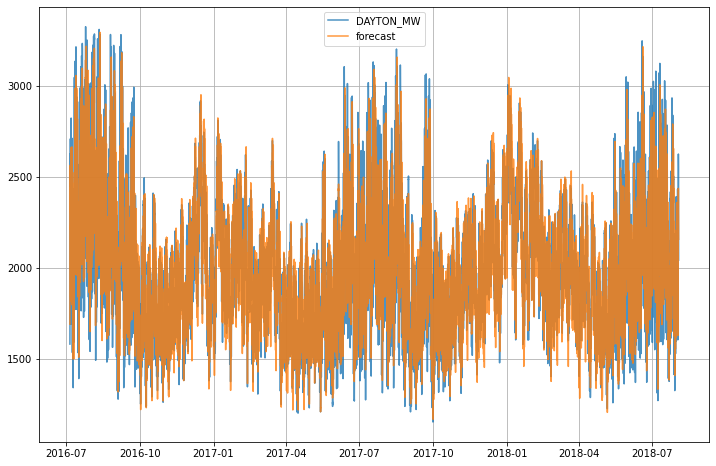

In [ ]:
import matplotlib.pyplot as plt
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['DAYTON_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://58b2a6d3-d804-43c5-8e1a-6c1e39cdcb77/assets


In [ ]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = d['DAYTON_MW'].tail(lag_model*2).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)
yhat


array([[1948.299 ],
       [1947.7809],
       [1947.97  ],
       [1628.0817],
       [1647.1693],
       [1675.68  ],
       [1730.432 ],
       [1992.2137],
       [2204.7427],
       [2062.137 ],
       [2096.7224],
       [2126.3054],
       [2158.6301],
       [2409.2485],
       [2427.1235],
       [2436.9634],
       [2425.7356],
       [2402.728 ],
       [2311.5254],
       [2278.1428],
       [2241.2173],
       [2204.6367],
       [2161.3545],
       [2156.91  ]], dtype=float32)